In [72]:
import autograd.numpy as np

In [73]:
def learn_HAT_adagrad_static(case, E_np_masked, K, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, beta=1, c=3):


    def cost_static_fact(H, A, T, F, K, E_np_masked,  case, beta=1):
    
        HAT = multiply_case(H, A, T, case)
        mask = ~np.isnan(E_np_masked)
        error_1 = (HAT - E_np_masked)[mask].flatten()
        
        mask = ~np.isnan(K)
        error_2 = (K-np.dot(H, F))[mask].flatten()
        
        
        
        return np.sqrt((error_1 ** 2).mean()) + beta * np.sqrt((error_2 ** 2).mean())

    
    cost = cost_static_fact


    mg = multigrad(cost, argnums=[0, 1, 2, 3])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)
    # F is h X c
    F = np.random.rand(a, c )
    
    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)
    sum_square_gradients_F = np.zeros_like(F)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    Fs = [F.copy()]
    costs = []
   
    HATs = [multiply_case(H, A, T, 2)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t, del_f = mg(H, A, T, F, K, E_np_masked,  case, beta)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)
        sum_square_gradients_F += eps + np.square(del_f)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))
        lr_f = np.divide(lr, np.sqrt(sum_square_gradients_F))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        F -= lr_f * del_f
       
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        F[F < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        Fs.append(H.copy())
        costs.append(cost(H, A, T, F, K, E_np_masked,  case, beta))
        HATs.append(multiply_case(H, A, T, 2))
        if i % 500 == 0:
            if dis:
                print(costs[-1])
    return H, A, T, F, Hs, As, Ts, HATs, costs


In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [5]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [64]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [74]:
a = 4
b = 2
K = static_sd

A_sd_s = []
A_au_s = []
for beta in [0, 1e-2, 1, 10, 100]:
    print(beta)
    print("*"*80)
    H_sd, A_sd, T_sd, F_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_static(case, tensor, static_sd, a, b, 1000, 0.1, True, beta=beta)

    H_au, A_au, T_au, F_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_static(case, au_tensor, static_au, a, b, 1000, 0.1, True, beta=beta)
    A_sd_s.append(A_sd_s)
    A_au_s.append(A_au_s)

0
********************************************************************************
215.588833844
42.1531116306
498.951535163
130.659881474
0.01
********************************************************************************
215.824618681
41.6501053351
498.953260089
125.313914917
1
********************************************************************************
216.39167127
39.6681619238
499.349666146
127.920826617
10
********************************************************************************
222.158042522
40.9184775682
503.466158875
128.206482778
100
********************************************************************************
253.951159903
52.6724565766
542.551901961
178.951382107


In [69]:
import matplotlib.pyplot as plt
from plot_functions import *

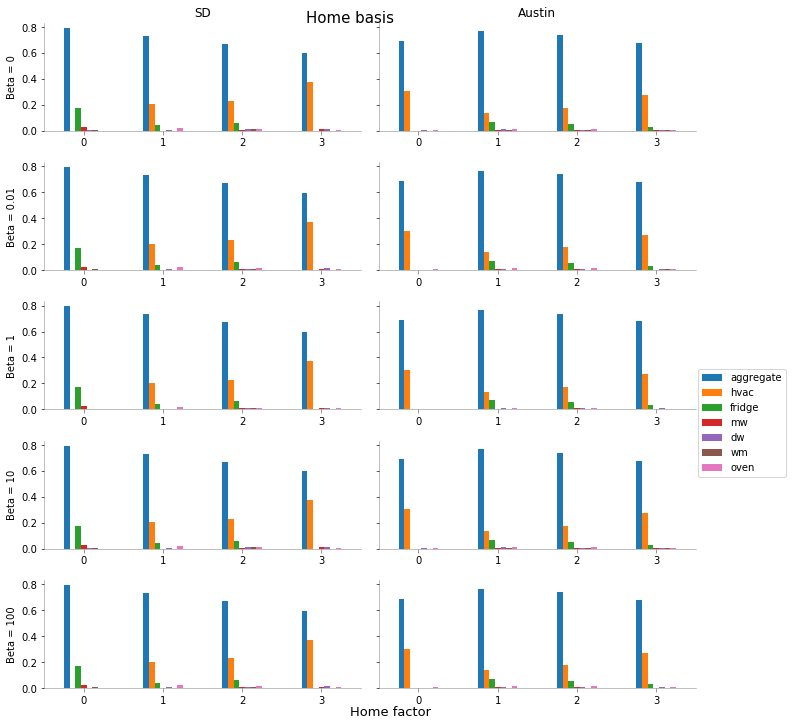

In [87]:
fig, ax  = plt.subplots(nrows=5, ncols=2, figsize=(10, 10), sharey=True)
for row, beta in enumerate([0, 1e-2, 1, 10, 100]):

    e = pd.DataFrame(np.einsum('ahs -> ah', A_sd), index=APPLIANCES_ORDER)
    e.div(e.sum()).T.plot(kind='bar', ax=ax[row, 0], rot=0, legend=False)

    e = pd.DataFrame(np.einsum('ahs -> ah', A_au), index=APPLIANCES_ORDER)
    e.div(e.sum()).T.plot(kind='bar', ax=ax[row, 1], rot=0, legend=False)
    #plt.legend(bbox_to_anchor=(1.34,1))
    format_axes(ax[row, 0])
    format_axes(ax[row, 1])
    ax[row, 0].set_ylabel("Beta = {}".format(beta))
    
fig.text( 0.5, 0 ,"Home factor", fontsize=(13))
ax[0, 0].set_title("SD")
ax[0, 1].set_title("Austin")

plt.legend(bbox_to_anchor=(1.3,3))
plt.suptitle("Home basis", fontsize=(15))
plt.tight_layout()

In [55]:
%matplotlib inline

In [56]:
pd.DataFrame(H).mean()

0    0.854817
1    0.558333
2    0.693018
3    1.363405
dtype: float64

In [60]:
pd.DataFrame(np.dot(H, F)).head(10)

,0,1,2
0,1.050996,0.279704,0.636058
1,0.386450,0.107866,0.908022
2,2.627626,1.672551,2.617946
3,0.389979,0.430752,1.852649
4,0.509308,0.440100,1.418286
5,0.387935,0.248847,0.499262
6,1.125175,0.269533,0.349545
7,0.541802,0.179595,1.444732
8,0.346416,0.248469,0.498499
9,1.973251,0.685454,1.108058


In [63]:
pd.DataFrame(K).head(10)

,0,1,2
0,NaN,NaN,NaN
1,0.38875,NaN,NaN
2,NaN,NaN,NaN
3,0.39375,NaN,NaN
4,0.51250,NaN,NaN
5,0.38875,0.25,0.5
6,NaN,NaN,NaN
7,0.54500,NaN,NaN
8,0.34750,0.25,0.5
9,NaN,NaN,NaN
